In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)


In [2]:
import pandas as pd
import numpy as np
from joblib import dump
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from src.io_utils import load_df
from src.config import COLS, SEED
from src.eval_utils import compute_metrics, save_json, plot_confusion


In [3]:
X_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/X_train.csv")
Y_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/y_train.csv")
X_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/X_test.csv")
Y_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/y_test.csv")

MODEL_PATH    = os.path.join(PROJECT_ROOT, "models/rf_baseline.pkl")
REPORTS_JSON  = os.path.join(PROJECT_ROOT, "reports/rf_metrics.json")
FIG_CM_RAW    = os.path.join(PROJECT_ROOT, "figures/rf_confusion_raw.png")
FIG_CM_NORM   = os.path.join(PROJECT_ROOT, "figures/rf_confusion_norm.png")
FIG_FEAT_IMP  = os.path.join(PROJECT_ROOT, "figures/rf_feature_importance.png")


In [4]:
# Optional SMOTE artifacts (if present)
X_TRAIN_SM_PATH = os.path.join(PROJECT_ROOT, "data/processed/X_train_sm.csv")
Y_TRAIN_SM_PATH = os.path.join(PROJECT_ROOT, "data/processed/y_train_sm.csv")

USE_SMOTE = os.path.exists(X_TRAIN_SM_PATH) and os.path.exists(Y_TRAIN_SM_PATH)
if USE_SMOTE:
    print("Found SMOTE training files; will offer to use them in tuning.")
else:
    print("No SMOTE training files found; proceeding with original training set.")

Found SMOTE training files; will offer to use them in tuning.


In [5]:
X_train = load_df(X_TRAIN_PATH)
y_train = load_df(Y_TRAIN_PATH)["Target"]
X_test  = load_df(X_TEST_PATH)
y_test  = load_df(Y_TEST_PATH)["Target"]

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train class ratio:\n", y_train.value_counts(normalize=True).round(3))
print("Test  class ratio:\n", y_test.value_counts(normalize=True).round(3))


Train: (3539, 18)  Test: (885, 18)
Train class ratio:
 Target
2    0.499
0    0.321
1    0.179
Name: proportion, dtype: float64
Test  class ratio:
 Target
2    0.499
0    0.321
1    0.180
Name: proportion, dtype: float64


In [6]:
# ===== RandomForest with CV tuning & class balance =====
# Choose train set: original or SMOTE
Xtr, ytr = (X_train, y_train)
# If you want to force SMOTE for this run, flip the flag:
# USE_SMOTE = True
if USE_SMOTE:
    try:
        Xtr = load_df(X_TRAIN_SM_PATH)
        ytr = load_df(Y_TRAIN_SM_PATH)["Target"]
        print("Using SMOTE-oversampled training set for tuning.")
    except Exception as e:
        print("Failed to load SMOTE data; falling back to original. Reason:", e)
        Xtr, ytr = (X_train, y_train)

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Base RF (class-weighted)
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=SEED,
)

# Small param search space (fast-ish; maximizes f1_macro)
param_dist = {
    'n_estimators': [400, 600, 800],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=25,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)

search.fit(Xtr, ytr)
rf_best = search.best_estimator_
print("Best params:", search.best_params_)


Using SMOTE-oversampled training set for tuning.
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [7]:
# Pick the tuned model if present; else the last-defined rf
model = rf_best if 'rf_best' in globals() else rf

y_pred = model.predict(X_test)

label_names = ["Dropout", "Graduate", "Enrolled"]  # ensure this matches your label encoding order
labels = sorted(y_train.unique())

metrics = compute_metrics(y_test, y_pred, labels=labels, label_names=label_names)
print("Accuracy:", round(metrics["accuracy"], 4))
print(pd.DataFrame(metrics["per_class"]).T)

save_json(metrics, REPORTS_JSON)
print("Saved metrics ->", REPORTS_JSON)


Accuracy: 0.7175
          precision    recall        f1  support
Dropout    0.795181  0.697183  0.742964    284.0
Graduate   0.384211  0.459119  0.418338    159.0
Enrolled   0.816143  0.823529  0.819820    442.0
Saved metrics -> /home/glinux/Projects/Skole/AnvendtData/reports/rf_metrics.json


Saved confusion matrices -> /home/glinux/Projects/Skole/AnvendtData/figures/rf_confusion_raw.png  &  /home/glinux/Projects/Skole/AnvendtData/figures/rf_confusion_norm.png


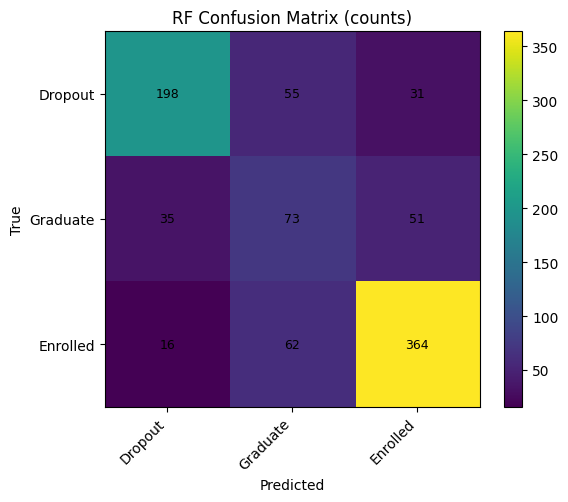

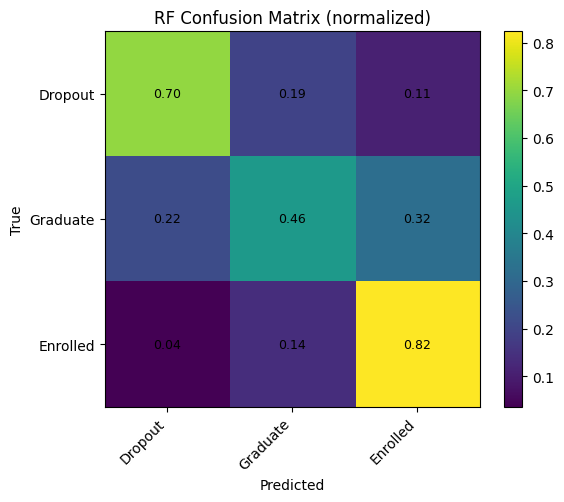

In [8]:
plot_confusion(y_test, y_pred, label_names=label_names, normalize=False,
               title="RF Confusion Matrix (counts)", save_path=FIG_CM_RAW)
plot_confusion(y_test, y_pred, label_names=label_names, normalize=True,
               title="RF Confusion Matrix (normalized)", save_path=FIG_CM_NORM)
print("Saved confusion matrices ->", FIG_CM_RAW, " & ", FIG_CM_NORM)


In [9]:
model = rf_best if 'rf_best' in globals() else rf

importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top = importances.head(15)

plt.figure(figsize=(7, 5))
top.iloc[::-1].plot(kind='barh')
plt.title("Random Forest — Top Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(FIG_FEAT_IMP, dpi=150, bbox_inches='tight')
plt.close()
print("Saved feature importance ->", FIG_FEAT_IMP)

dump(model, MODEL_PATH)
print("Saved model ->", MODEL_PATH)


Saved feature importance -> /home/glinux/Projects/Skole/AnvendtData/figures/rf_feature_importance.png
Saved model -> /home/glinux/Projects/Skole/AnvendtData/models/rf_baseline.pkl
